# Random walks $R_t$ factor with Student-t likelihood of daily cases with adjusted measurement for weekdays

In [1]:
from datetime import date
import locale
import calendar

import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import theano.tensor as tt

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize': [10, 5], 'figure.dpi': 95})

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/treker-mk/data/master/csv/stats.csv')
data = data.assign(date = pd.to_datetime(data.date))
data = data[data.date.dt.date >= date(2020, 3, 20)]
data.tail(8)[['date', 'cases.confirmed']]

,date,cases.confirmed
554,2021-08-31,906.0
555,2021-09-01,760.0
556,2021-09-02,722.0
557,2021-09-03,708.0
558,2021-09-04,459.0
559,2021-09-05,199.0
560,2021-09-06,682.0
561,2021-09-07,702.0


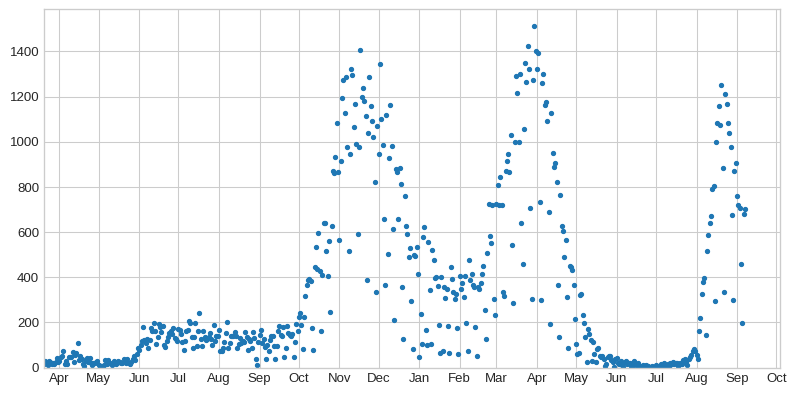

In [4]:
plt.scatter(data.date, data['cases.confirmed'], marker='.')
plt.gca().set(ylim=(-1, None), xlim=(data.date.min(), None))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

### Model

We model the new daily cases as simple reproduction with a Student's t likelihood:

$$ \text{observed}_t \sim t_\nu(\mu_t, \alpha) $$

The daily average is censored by a factor $ w_d $  depending on the day of week:

$$ \mu_t = w_{d_t} \overline \mu_t $$

where the true average is simply a multiple of the day before:

$$ \overline \mu_{t+1} = R_t  \overline \mu_t $$

which can be rewriten as (note: $ \overline \mu_0 = 1$):

$$ \log \overline \mu_{t+1} = \log \overline \mu_{t} + \log R_t $$

$$ \log \overline \mu_t = \log \overline  \mu_0 \sum_{\tau=1}^t \log R_{\tau} $$

We will model the $R_t$ as Gaussian random walk prior in the log scale (the factor is always positive):

$$ \log R_{t+1} \sim \mathcal{N}(\log R_t, \sigma^2) $$

and a regularizing hyperprior for $\sigma$:

$$ \sigma \sim \text{Half-Normal}(0.05^2) $$

The censoring should average out on a weekly level, i.e.:

$$ \sum w_d = 7 $$


therefore, we can use a Dirichlet prior:

$$ \frac{\mathbf w }{7} \sim \text{Dirichlet}(\mathbf 1) $$

Finally, for the scale parameter we will use log-normal prior, to avoid low values that might introduce an unidentifiability issues with respect to $\sigma$:

$$ \alpha \sim \text{Log-Normal}(\log 50, 1) $$

and for the degrees of freedom a standardized default prior:

$$ \nu \sim \text{Gamma}(2, 0.1) $$

In [5]:
mu0 = data['cases.confirmed'].values[0]

with pm.Model() as model6:
    N = data.shape[0]
    weekday_i = data.date.dt.weekday.values

    sigma = pm.HalfNormal('sigma', 0.05)
    logR = pm.GaussianRandomWalk(
        'logR',
        init=pm.Normal.dist(0, 0.2),
        sigma=sigma,
        shape=N)

    R = pm.Deterministic('R', tt.exp(logR))
    mu_true = pm.Deterministic('mu_true', mu0 * tt.exp(tt.cumsum(logR)))

    # weekday censoring
    _w = pm.Dirichlet('_w', a=np.ones(7), shape=7, testval=np.ones(7)/7)
    w = pm.Deterministic('w', 7*_w)

    mu_observed = pm.Deterministic('mu_observed', mu_true * w[weekday_i])

    alpha = pm.Lognormal('alpha', np.log(20), 1)
    nu = pm.Gamma('nu', 2, 0.1)
    pm.StudentT(
        'obs', mu=mu_observed, sigma=alpha, nu=nu,
        observed=data['cases.confirmed'].values)

    trace6 = pm.sample(7000, tune=3000, chains=2, cores=2)

/tmp/ipykernel_475949/1432559181.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace6 = pm.sample(7000, tune=3000, chains=2, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, alpha, _w, logR, sigma]


Sampling 2 chains for 3_000 tune and 7_000 draw iterations (6_000 + 14_000 draws total) took 1330 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


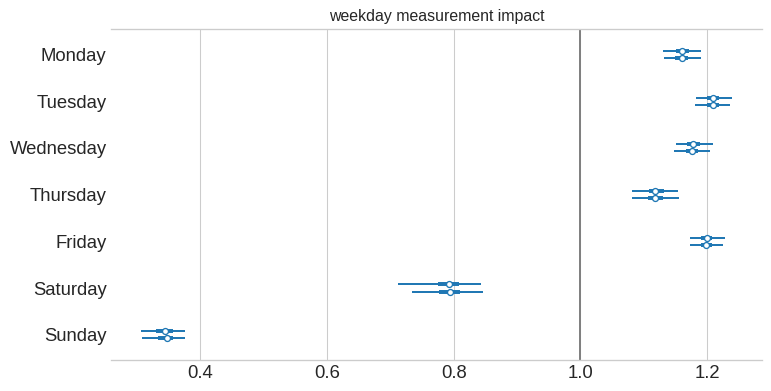

In [6]:
az.plot_forest(trace6, var_names=['w'], hdi_prob=0.95, figsize=(8, 4))
plt.gca().set(title='weekday measurement impact',
              yticklabels=(tuple(calendar.day_name)*2)[13:6:-1])
plt.axvline(1, color='gray')
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


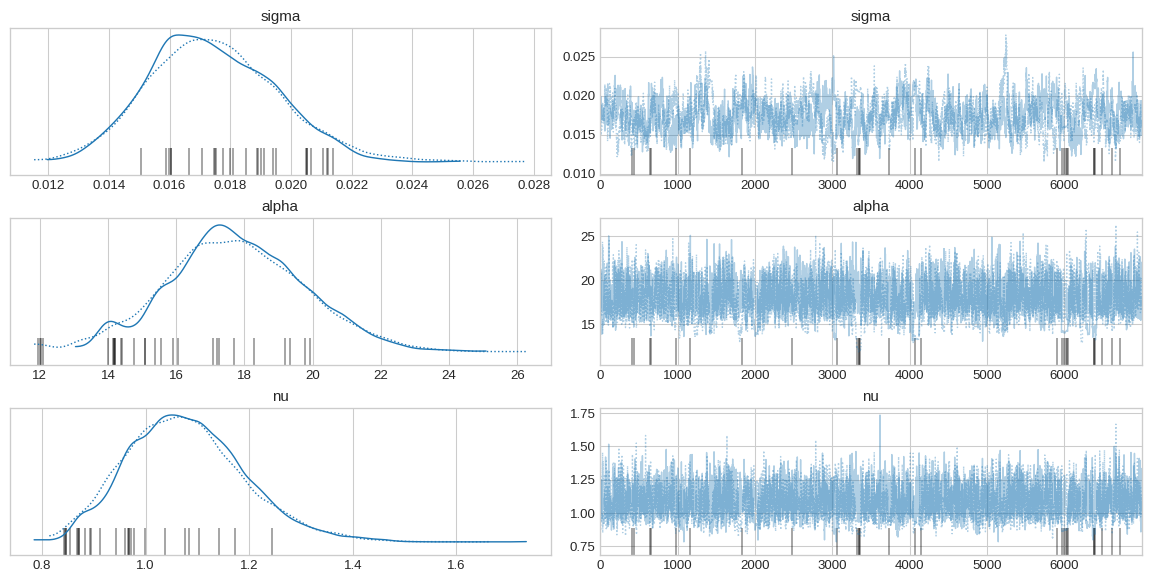

In [7]:
az.plot_trace(trace6, var_names=['sigma', 'alpha', 'nu'])
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other fun

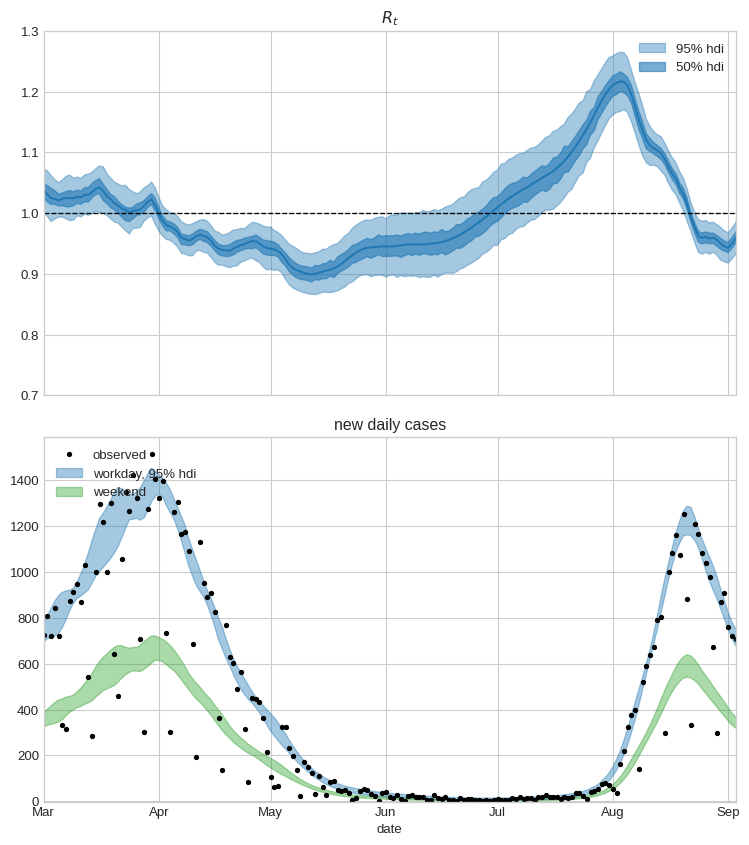

In [8]:
locale.setlocale(6, 'en_US.UTF-8')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9), sharex=True)
tmp = az.hdi(trace6['R'] , hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
tmp = tmp.assign(mean_ = trace6['R'].mean(axis=0))
tmp.mean_.plot(ax=ax1, label='')
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, color='C0', label='95% hdi')

tmp = az.hdi(trace6['R'] , hdi_prob=0.5)
tmp = pd.DataFrame(tmp, index=data['date'])
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.6, color='C0', label='50% hdi')

ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R_t$', xlabel='date', ylim=(0.7, 1.3))
ax1.legend()

# workday 6
tmp = az.hdi(trace6['mu_true'] * trace6['w'][:, :5].mean(axis=1).reshape(-1, 1), hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='workday, 95% hdi', color='C0')

# weekend 6
tmp = az.hdi(trace6['mu_true'] * trace6['w'][:, 5:].mean(axis=1).reshape(-1, 1), hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='weekend', color='C2')

ax2.plot(data['date'], data['cases.confirmed'],
         color='k', label='observed', marker='.', linewidth=0)
ax2.set(title='new daily cases', xlabel='date', ylim=(-1, None),
        xlim=(date(2021, 3, 1), data.iloc[-5].date))

ax2.legend(loc='upper left')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

fig.tight_layout()
fig.savefig('mk_daily_R_en.png')
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other fun

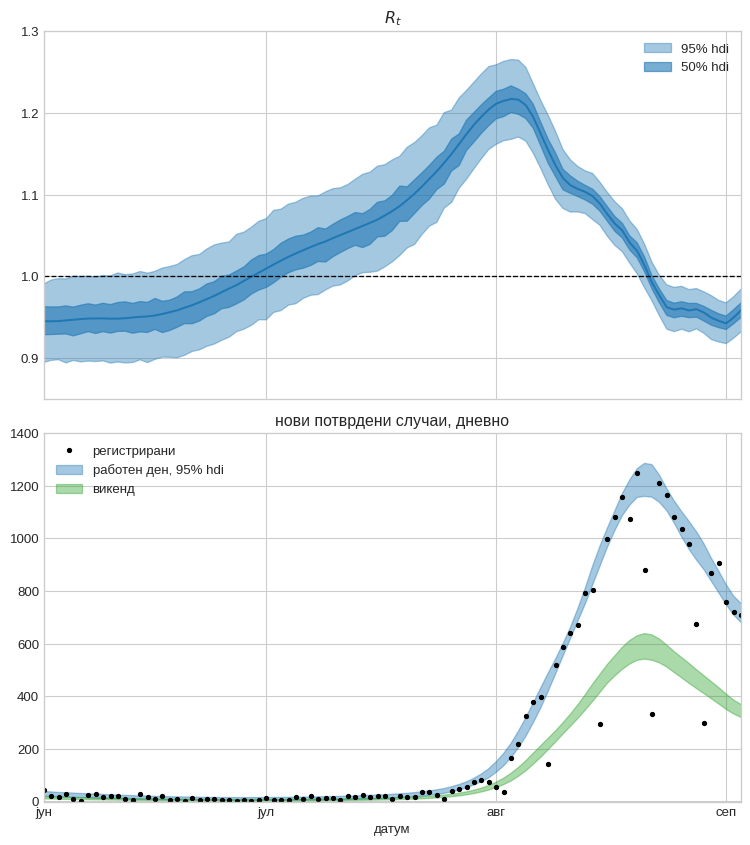

In [9]:
locale.setlocale(6, 'mk_MK.UTF-8')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9), sharex=True)
tmp = az.hdi(trace6['R'] , hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
tmp = tmp.assign(mean_ = trace6['R'].mean(axis=0))
tmp.mean_.plot(ax=ax1, label='')
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, color='C0', label='95% hdi')

tmp = az.hdi(trace6['R'] , hdi_prob=0.5)
tmp = pd.DataFrame(tmp, index=data['date'])
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.6, color='C0', label='50% hdi')

ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R_t$', xlabel='датум', ylim=(0.85, 1.3))
ax1.legend()

tmp = az.hdi(trace6['mu_true'] * trace6['w'][:, :5].mean(axis=1).reshape(-1, 1), hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='работен ден, 95% hdi', color='C0')

tmp = az.hdi(trace6['mu_true'] * trace6['w'][:, 5:].mean(axis=1).reshape(-1, 1), hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='викенд', color='C2')

ax2.plot(data['date'], data['cases.confirmed'],
         color='k', label='регистрирани', marker='.', linewidth=0)
ax2.set(title='нови потврдени случаи, дневно', xlabel='датум', ylim=(-1, 1400),
        xlim=(date(2021, 6, 1), data.iloc[-5].date))

ax2.legend(loc='upper left')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

fig.tight_layout()
fig.savefig('mk_daily_R.png')
None

---

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other fun

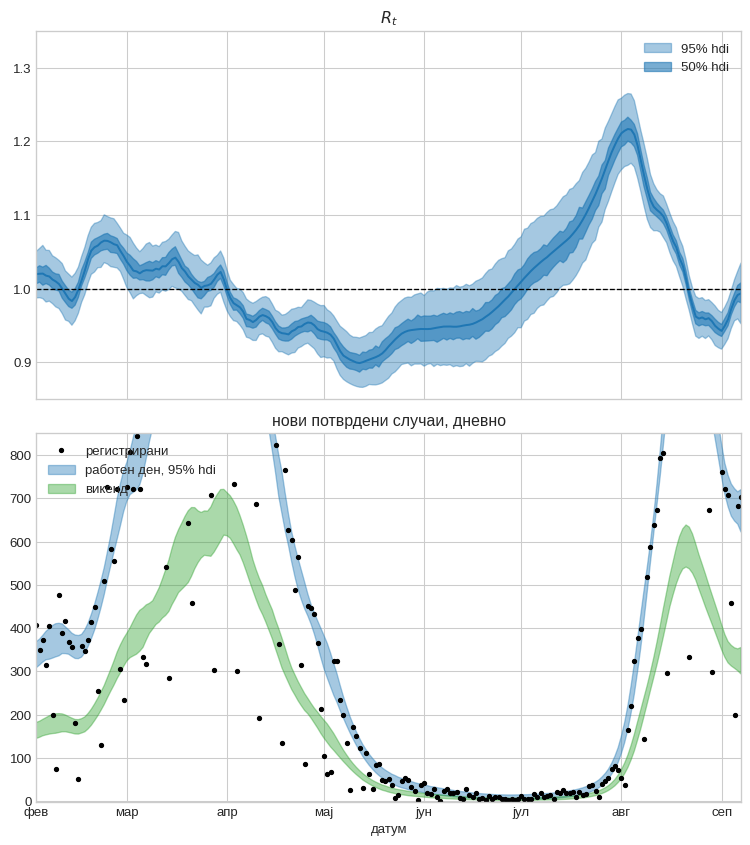

In [10]:
locale.setlocale(6, 'mk_MK.UTF-8')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9), sharex=True)
tmp = az.hdi(trace6['R'] , hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
tmp = tmp.assign(mean_ = trace6['R'].mean(axis=0))
tmp.mean_.plot(ax=ax1, label='')
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, color='C0', label='95% hdi')

tmp = az.hdi(trace6['R'] , hdi_prob=0.5)
tmp = pd.DataFrame(tmp, index=data['date'])
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.6, color='C0', label='50% hdi')

ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R_t$', xlabel='датум', ylim=(0.85, 1.35))
ax1.legend()

tmp = az.hdi(trace6['mu_true'] * trace6['w'][:, :5].mean(axis=1).reshape(-1, 1), hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='работен ден, 95% hdi', color='C0')

tmp = az.hdi(trace6['mu_true'] * trace6['w'][:, 5:].mean(axis=1).reshape(-1, 1), hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='викенд', color='C2')

ax2.plot(data['date'], data['cases.confirmed'],
         color='k', label='регистрирани', marker='.', linewidth=0)
ax2.set(title='нови потврдени случаи, дневно', xlabel='датум', ylim=(-1, 850),
        xlim=(date(2021, 2, 1), None))

ax2.legend(loc='upper left')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

fig.tight_layout()
None